In [1]:
from langchain_core.messages import HumanMessage, BaseMessage
# from decouple import config
from typing import List, Sequence
import pprint
import os
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from gemini_llm import GeminiLLM


/Users/pdwivedi/miniconda3/envs/test/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
os.environ["GOOGLE_API_KEY"] = os.getenv("OPENAI_API_KEY") ## Put your OpenAI API key here
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY") ## Put your Langsmith API key here
os.environ["LANGCHAIN_HUB_API_KEY"] = os.getenv("LANGCHAIN_API_KEY") ## Put your Langsmith API key here
os.environ["LANGCHAIN_TRACING_V2"] = 'true' ## Set this as True
os.environ["LANGCHAIN_ENDPOINT"] = 'https://api.smith.langchain.com/' ## Set this as: https://api.smith.langchain.com/
os.environ["LANGCHAIN_HUB_API_URL"] = 'https://api.hub.langchain.com' ## Set this as : https://api.hub.langchain.com
os.environ["LANGCHAIN_PROJECT"] = 'llm-agents-planning'

## Define prompts for Generation and Reflection

![Reflection](images/reflection.png)

In [4]:
generation_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an AI assistant researcher tasked with sharing recipes based on the user's request. Share your top 3 recipes"
            " If the user provides critique, respond with a revised version of your previous attempts.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

llm = GeminiLLM(model='gemini-1.5-flash-latest', temperature=0.3)

generate_agent = generation_prompt | llm

In [5]:
result = generate_agent.invoke({"messages": ["Share breakfast recipes"]})
pprint.pprint(result)

('Here are 3 breakfast recipes for you:\n'
 '\n'
 '**1.  Overnight Oats:**\n'
 '\n'
 '* **Ingredients:**\n'
 '    * 1/2 cup rolled oats\n'
 '    * 1/2 cup milk (any kind)\n'
 '    * 1/4 cup yogurt (Greek or regular)\n'
 '    * 1 tablespoon chia seeds\n'
 '    * 1 teaspoon honey or maple syrup (optional)\n'
 '    * 1/4 teaspoon vanilla extract\n'
 '    * Toppings of your choice (fruit, nuts, granola)\n'
 '\n'
 '* **Instructions:**\n'
 '    1. Combine all ingredients in a jar or container.\n'
 '    2. Stir well and refrigerate overnight.\n'
 '    3. In the morning, top with your favorite toppings and enjoy!\n'
 '\n'
 '**2.  Breakfast Burrito:**\n'
 '\n'
 '* **Ingredients:**\n'
 '    * 1 large flour tortilla\n'
 '    * 1 egg\n'
 '    * 1/4 cup shredded cheese\n'
 '    * 1/4 cup salsa\n'
 '    * 1/4 cup black beans (canned or cooked)\n'
 '    * 1/4 cup chopped onion\n'
 '    * 1/4 cup chopped bell pepper\n'
 '\n'
 '* **Instructions:**\n'
 '    1. Scramble the egg in a pan over medium heat.

In [6]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        #  this needs to be a tuple so do not forget the , at the end
        (
            "system",
            "You are a food critic who focuses specially on healthy organic food."
            "Provide detailed feedback to the recipes presented to you to make them healthy."
            "You also want to focus on food that is protien rich, not very fatty and not with too much meat"
            "Provide your feedback as a numbered list"
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

reflect_agent = reflection_prompt | llm

In [7]:
result = reflect_agent.invoke({"messages": [result]})
pprint.pprint(result)

('Here is my feedback on your breakfast recipes, focusing on healthy, '
 'protein-rich, and low-fat options:\n'
 '\n'
 "1. **Overnight Oats:** This is a great start! It's naturally low in fat and "
 'can be easily customized for protein. Here are some tweaks:\n'
 '\n'
 '    * **Protein Boost:**  Swap the milk for unsweetened almond milk or soy '
 'milk for a boost of protein.  Add a scoop of protein powder or a tablespoon '
 'of chia seeds for extra protein.\n'
 '    * **Fat Reduction:**  Use plain yogurt instead of flavored yogurt, which '
 'can be high in added sugar.  Skip the honey or maple syrup, or use a small '
 'amount of stevia or a natural sweetener like monk fruit.\n'
 '    * **Fiber Power:**  Add flaxseeds or ground chia seeds for added fiber '
 'and omega-3 fatty acids.\n'
 '    * **Topping Ideas:**  Choose protein-rich toppings like nuts, seeds, or '
 'a sprinkle of shredded coconut. Opt for fresh or frozen fruit over sugary '
 'jams or syrups.\n'
 '\n'
 '2. **Breakfast B

## Define the Langgraph Graph

In [8]:
from langgraph.graph import MessageGraph, END

### Define generate and reflect nodes

In [9]:
async def generation_node(state: Sequence[BaseMessage]):
    return await generate_agent.ainvoke({"messages": state})

async def reflection_node(state: Sequence[BaseMessage]):
    return await reflect_agent.ainvoke({"messages": state})


In [10]:
builder = MessageGraph()
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.set_entry_point("generate")


def should_continue(state: List[BaseMessage]):
    if len(state) > 4:
        return END
    return "reflect"


builder.add_conditional_edges("generate", should_continue)
builder.add_edge("reflect", "generate")
graph = builder.compile()

In [11]:
graph.get_graph().print_ascii()

          +-----------+            
          | __start__ |            
          +-----------+            
                *                  
                *                  
                *                  
          +----------+             
          | generate |             
          +----------+             
          ...        ...           
         .              .          
       ..                ..        
+---------+           +---------+  
| reflect |           | __end__ |  
+---------+           +---------+  


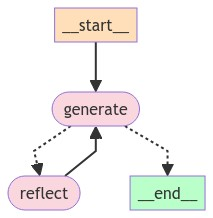

In [12]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

### Start graph execution

In [13]:
async for event in graph.astream(
    [
        HumanMessage(
            content="Share some breakfast recipes"
        )
    ],
):
    print(event)
    print("---")

{'generate': 'Here are 3 breakfast recipes for you:\n\n1. **Overnight Oats:** \n    * Combine 1/2 cup rolled oats, 1/2 cup milk (dairy or non-dairy), 1/4 cup yogurt, 1 tablespoon chia seeds, and a drizzle of honey or maple syrup in a jar. \n    * Stir well and refrigerate overnight. \n    * In the morning, top with your favorite fruits, nuts, and seeds.\n\n2. **Breakfast Burrito:**\n    * Scramble 2 eggs with a sprinkle of salt and pepper. \n    * Warm a large flour tortilla in a pan. \n    * Fill the tortilla with scrambled eggs, shredded cheese, diced tomatoes, onions, and your choice of protein (like beans, chorizo, or leftover chicken). \n    * Roll up the tortilla and enjoy!\n\n3. **Avocado Toast:**\n    * Toast a slice of bread. \n    * Mash half an avocado with a fork. \n    * Spread the mashed avocado on the toast. \n    * Season with salt, pepper, and a squeeze of lemon juice. \n    * Top with a sprinkle of red pepper flakes for a kick. \n'}
---
{'reflect': "These are some gre